37902 Foundation of Advanced Quantitative Marketing

Li Liu

2/9/2019

### Task
1) Estimate the continuous RC model. Try different numbers of draws as well as antithetic draws. For the same number of draws (say 30, try 30 random draws and 15 draws + the corresponding antithetic draws and compare the performance). The parameters may look different but what you want to check are the elasticities

2) Try computing the elasticities and posterior parameter estimates for each household. For those of you familiar with cluster analysis you may then want to cluster based on these estimates to see if the segments you create are similar to those from the discrete heterogeneity case.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
pd.options.display.max_colwidth = 1000
from matplotlib.mlab import bivariate_normal
from mpl_toolkits.mplot3d import Axes3D

### Yogurt100N Sales Data

In [2]:
df=pd.read_excel("Yogurt100N.csv.xlsx")
Xtab=df.groupby(["Pan I.D."]).mean()
df.head()

,Pan I.D.,Expend $,Income,HH Size,IPT,Quantity,Brand 1,Brand 2,Brand 3,Brand 4,Feature 1,Feature 2,Feature 3,Feature 4,Price 1,Price 2,Price 3,Price 4,PanelistFirstObs
0,1,40.900002,9,2,5,2,0,0,0,1,0,0,0,0,0.108,0.081,0.061,0.079,1
1,1,16.809999,9,2,5,2,0,1,0,0,0,0,0,0,0.108,0.098,0.064,0.075,0
2,1,4.060000,9,2,1,2,0,1,0,0,0,0,0,0,0.108,0.098,0.061,0.086,0
3,1,34.459999,9,2,4,2,0,1,0,0,0,0,0,0,0.108,0.098,0.061,0.086,0
4,1,8.390000,9,2,7,2,0,1,0,0,0,0,0,0,0.125,0.098,0.049,0.079,0


### Continuous RC model

In [128]:
def crit(params,D,antithetic):
    '''
    Function computes the negative log likelihood of Random Coefficients model
    Input:
    params (initial values)
    D (number of draws)
    Antithetic (if true, half of the draws are antithetic)
    '''
    a1,a2,a3,bf,bp,a,b,c,d,e,f,g,h,i,j,k,l,m,n,p=params
    
    #Define the upper-triangular matrix Gamma
    r=np.array([[a,b,c,d,e], [0,f,g,h,i],[0,0,j,k,l],[0,0,0,m,n],[0,0,0,0,p]])
    
    #Make D draws from 5 univariate standard normal variables.
    #Construct Q=D*M matrix
    np.random.seed=100
    if antithetic==False:
        Q=np.random.normal(0,1,D*5).reshape(D,5)
    else:
        a=np.random.normal(0,1,int((D/2))*5).reshape(int((D/2)),5)
        Q=np.concatenate((a,-a))
    
    global QGT, liktab
    #Post-multiply Q by r & add mean parameters to the QG matrix
    #Each row of QGT is like the parameters for each of the S segments in the latent class model
    QGT=Q@r+np.array([a1,a2,a3,bf,bp]) #D*M matrix
    
    liktab=pd.DataFrame({"ID":df["Pan I.D."]}) #New DataFrame for storing likelihoods
    b1tab=pd.DataFrame({"ID":df["Pan I.D."]}) #New DataFrame for probability of choosing b1 
    b2tab=pd.DataFrame({"ID":df["Pan I.D."]}) #New DataFrame for probability of choosing b2
    b3tab=pd.DataFrame({"ID":df["Pan I.D."]}) #New DataFrame for probability of choosing b3 
    b4tab=pd.DataFrame({"ID":df["Pan I.D."]}) #New DataFrame for probability of choosing b4 
    a1tab=pd.DataFrame({"ID":df["Pan I.D."]}) #New DataFrame for a1
    a2tab=pd.DataFrame({"ID":df["Pan I.D."]}) #New DataFrame for a2
    a3tab=pd.DataFrame({"ID":df["Pan I.D."]}) #New DataFrame for a3
    bftab=pd.DataFrame({"ID":df["Pan I.D."]}) #New DataFrame for bf
    bptab=pd.DataFrame({"ID":df["Pan I.D."]}) #New DataFrame for bp
  
    #Compute likilihood at each simulation
    for i in range(D):
        #coef=QGT[i].tolist()[0] #Get coefficients in the ith simulation
        coef=QGT[i]
        ev1=np.exp(coef[0]+coef[3]*df['Feature 1']+coef[4]*df['Price 1'])
        ev2=np.exp(coef[1]+coef[3]*df['Feature 2']+coef[4]*df['Price 2'])
        ev3=np.exp(coef[2]+coef[3]*df['Feature 3']+coef[4]*df['Price 3'])
        ev4=np.exp(0+coef[3]*df['Feature 4']+coef[4]*df['Price 4'])
        denom=ev1+ev2+ev3+ev4
        liktab[i]=(ev1*df['Brand 1']+ev2*df['Brand  2']+ev3*df['Brand 3']+ev4*df['Brand 4'])/denom
        b1tab[i]=ev1/denom
        b2tab[i]=ev2/denom
        b3tab[i]=ev3/denom
        b4tab[i]=ev4/denom
        a1tab[i]=coef[0]
        a2tab[i]=coef[1]
        a3tab[i]=coef[2]
        bftab[i]=coef[3]
        bptab[i]=coef[4]
        
    global likagg, b1agg, b2agg, b3agg, b4agg, a1agg, a2agg, a3agg, bfagg, bpagg
    #Aggregate by households
    likagg= liktab.groupby("ID").prod()
    b1agg= b1tab.groupby("ID").mean()
    b2agg= b2tab.groupby("ID").mean()
    b3agg= b3tab.groupby("ID").mean()
    b4agg= b4tab.groupby("ID").mean()
    a1agg= a1tab.groupby("ID").mean()
    a2agg= a2tab.groupby("ID").mean()
    a3agg= a3tab.groupby("ID").mean()
    bfagg= bftab.groupby("ID").mean()
    bpagg= bptab.groupby("ID").mean()
    
    #Weighted average for parameters
    a1agg=a1agg*likagg/(likagg.sum(axis=0))
    a2agg=a2agg*likagg/(likagg.sum(axis=0))
    a3agg=a3agg*likagg/(likagg.sum(axis=0))
    bfagg=bfagg*likagg/(likagg.sum(axis=0))
    bpagg=bpagg*likagg/(likagg.sum(axis=0))
    
       
    #Average across draws
    #tab=(tab*tab).div(tab["sum"],axis=0)
    likagg["avg"]=likagg.mean(axis=1)
    b1agg=b1agg.mean(axis=1)
    b2agg=b2agg.mean(axis=1)
    b3agg=b3agg.mean(axis=1)
    b4agg=b4agg.mean(axis=1)
    a1agg=a1agg.mean(axis=1)
    a2agg=a2agg.mean(axis=1)
    a3agg=a3agg.mean(axis=1)
    bfagg=bfagg.mean(axis=1)
    bpagg=bpagg.mean(axis=1)
    
    #Log likelihoods of N households
    LL=np.sum(np.log(likagg["avg"]))
    
    return -LL

#### 30 draws of the continuous RC model

In [147]:
para_init=[1.39,0.64,-3.09,0.49,-37,1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
args=(30,False)
results30 = opt.minimize(crit, para_init,args, tol=1e-10, method='L-BFGS-B')
a1,a2,a3,bf,bp,a,b,c,d,e,f,g,h,i,j,k,l,m,n,p = results30.x
print(" a1 (Mean preference for Brand 1):",a1,"\n",
      "a2 (Mean preference for Brand 2):",a2,"\n",
      "a3 (Mean preference for Brand 3):",a3,"\n",
      "bf (Coefficients for feature variable):",bf,"\n",
      "bp (Coefficients for price variable):",bp,"\n",
      "Maximized Log Likelihood:",-results30.fun)

 a1 (Mean preference for Brand 1): 2.552799184853363 
 a2 (Mean preference for Brand 2): 1.8015212692281095 
 a3 (Mean preference for Brand 3): -4.4776074395805665 
 bf (Coefficients for feature variable): 0.803170326411932 
 bp (Coefficients for price variable): -47.930642354893216 
 Maximized Log Likelihood: -1225.3415919038773


In [153]:
np.array([[a,b,c,d,e], [0,f,g,h,i],[0,0,j,k,l],[0,0,0,m,n],[0,0,0,0,p]]).round(1)

array([[  3.4,   4.1,   2.7,  -0.1, -13.5],
       [  0. ,   4. ,   0.5,  -0. , -12. ],
       [  0. ,   0. ,   5.5,  -0. ,  13.5],
       [  0. ,   0. ,   0. ,  -0.7,  30.3],
       [  0. ,   0. ,   0. ,   0. ,  12.8]])

In [148]:
print(results30)

      fun: 1225.3415919038773
 hess_inv: <20x20 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.61612978e-03,  8.04902811e-03, -1.25055521e-03, -4.09272616e-04,
       -4.54747351e-04, -6.43467502e-03,  8.79936124e-03, -1.45519152e-03,
        4.09272616e-04,  6.36646291e-04, -5.93445293e-03,  2.72848411e-04,
       -2.72848411e-03,  8.18545232e-04, -2.41016096e-03, -3.86535248e-04,
        2.27373675e-05, -2.50111043e-04, -6.59383659e-04,  1.09139364e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 7854
      nit: 339
   status: 0
  success: True
        x: array([ 2.55279918e+00,  1.80152127e+00, -4.47760744e+00,  8.03170326e-01,
       -4.79306424e+01,  3.39379581e+00,  4.11917560e+00,  2.65278472e+00,
       -1.12332705e-01, -1.35247042e+01,  4.01175231e+00,  4.76834815e-01,
       -2.77775839e-02, -1.20316811e+01,  5.50079982e+00, -1.30439658e-02,
        1.35144268e+01, -6.51449751e-01,  3.03088456e+01,  1.27560279e+01])


In [ ]:
a1l=[1.39]
a2l=[0.64]
a3l=[-3.09]
bfl=[0.49]
bpl=[-37]
a1l.append(a1)
a2l.append(a2)
a3l.append(a3)
bfl.append(bf)
bpl.append(bp)

#### 15 draws + 15 antithetic draws of  the continuous RC model

In [59]:
# Antithetic Draws 15 draws + the corresponding antithetic draws
para_init=[1.39,0.64,-3.09,0.49,-37,1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
args=(30,True)
results30_anti = opt.minimize(crit, para_init,args,tol=1e-20, method='L-BFGS-B')
a1,a2,a3,bf,bp,a,b,c,d,e,f,g,h,i,j,k,l,m,n,p = results30_anti.x
print(" a1 (Mean preference for Brand 1):",a1,"\n",
      "a2 (Mean preference for Brand 2):",a2,"\n",
      "a3 (Mean preference for Brand 3):",a3,"\n",
      "bf (Coefficients for feature variable):",bf,"\n",
      "bp (Coefficients for price variable):",bp,"\n",
      "Maximized Log Likelihood:",-results30_anti.fun)
a1l.append(a1)
a2l.append(a2)
a3l.append(a3)
bfl.append(bf)
bpl.append(bp)

 a1 (Mean preference for Brand 1): 1.3899991863467553 
 a2 (Mean preference for Brand 2): 0.6400012582713362 
 a3 (Mean preference for Brand 3): -3.0899997601663802 
 bf (Coefficients for feature variable): 0.48999964754704645 
 bp (Coefficients for price variable): -36.999998674362985 
 Maximized Log Likelihood: -1735.83274004157


In [60]:
np.matrix([[a,b,c,d,e], [0,f,g,h,i],[0,0,j,k,l],[0,0,0,m,n],[0,0,0,0,p]])

matrix([[0.99999816, 1.00000078, 1.00000065, 1.00000069, 0.9999985 ],
        [0.        , 0.99999783, 0.99999975, 1.00000196, 1.00000131],
        [0.        , 0.        , 0.99999949, 0.99999993, 1.0000002 ],
        [0.        , 0.        , 0.        , 0.99999933, 1.00000062],
        [0.        , 0.        , 0.        , 0.        , 0.99999942]])

#### 50 draws of the continuous RC model

In [35]:
para_init=[1.39,0.64,-3.09,0.49,-37,1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
args=(50,False)
results50 = opt.minimize(crit, para_init,args,tol=1e-20, method='L-BFGS-B')
a1,a2,a3,bf,bp,a,b,c,d,e,f,g,h,i,j,k,l,m,n,p = results50.x
print(" a1 (Mean preference for Brand 1):",a1,"\n",
      "a2 (Mean preference for Brand 2):",a2,"\n",
      "a3 (Mean preference for Brand 3):",a3,"\n",
      "bf (Coefficients for feature variable):",bf,"\n",
      "bp (Coefficients for price variable):",bp,"\n",
      "Maximized Log Likelihood:",-results50.fun)
a1l.append(a1)
a2l.append(a2)
a3l.append(a3)
bfl.append(bf)
bpl.append(bp)

 a1 (Mean preference for Brand 1): 1.3900000360839673 
 a2 (Mean preference for Brand 2): 0.6400000255016127 
 a3 (Mean preference for Brand 3): -3.090000144520476 
 bf (Coefficients for feature variable): 0.4899998147994362 
 bp (Coefficients for price variable): -36.99999996111722 
 Maximized Log Likelihood: -1238.847789989257


#### 25 draws + 25 antithetic draws of  the continuous RC model

In [37]:
para_init=[1.39,0.64,-3.09,0.49,-37,1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
args=(50,True)
results50_anti = opt.minimize(crit, para_init,args,tol=1e-20, method='L-BFGS-B')
a1,a2,a3,bf,bp,a,b,c,d,e,f,g,h,i,j,k,l,m,n,p = results50.x
print(" a1 (Mean preference for Brand 1):",a1,"\n",
      "a2 (Mean preference for Brand 2):",a2,"\n",
      "a3 (Mean preference for Brand 3):",a3,"\n",
      "bf (Coefficients for feature variable):",bf,"\n",
      "bp (Coefficients for price variable):",bp,"\n",
      "Maximized Log Likelihood:",-results50_anti.fun)
a1l.append(a1)
a2l.append(a2)
a3l.append(a3)
bfl.append(bf)
bpl.append(bp)

 a1 (Mean preference for Brand 1): 1.3900000360839673 
 a2 (Mean preference for Brand 2): 0.6400000255016127 
 a3 (Mean preference for Brand 3): -3.090000144520476 
 bf (Coefficients for feature variable): 0.4899998147994362 
 bp (Coefficients for price variable): -36.99999996111722 
 Maximized Log Likelihood: -1224.469005349486


#### Maximized Log Likelihood at large random draws

Maximized log likelohoods increases when there are more draws. Will it reach a peak at larger D?

In [ ]:
#New D
np.arange(100,500,50)

In [76]:
draws2=np.arange(100,500,50)
LL2=[]
for i in draws2:
    args=(int(i),True)
    results_test2 = opt.minimize(crit, para_init,args,tol=1e-20, method='L-BFGS-B')
    LL2.append(-results_test2.fun)

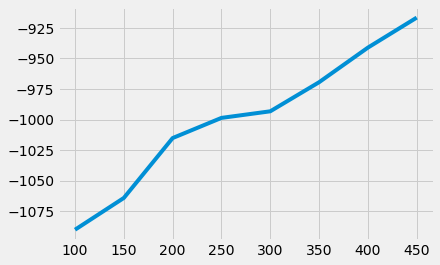

In [78]:
plt.plot(draws2,LL2)
plt.show()

### Elasticities 

Estimates are from RCM with 30 random draws.

Change the number of households to display in head()

In [136]:
# Own elasticities
e11= (bfagg*Xtab['Feature 1']+bpagg*Xtab['Price 1'])*(1-b1agg)
e22= (bfagg*Xtab['Feature 2']+bpagg*Xtab['Price 2'])*(1-b2agg)
e33= (bfagg*Xtab['Feature 3']+bpagg*Xtab['Price 3'])*(1-b3agg)
e44= (bfagg*Xtab['Feature 4']+bpagg*Xtab['Price 4'])*(1-b4agg)

# Cross elasticities
e21=e31=e41=-(bfagg*Xtab['Feature 1']+bpagg*Xtab['Price 1'])*b1agg
e12=e32=e42=-(bfagg*Xtab['Feature 2']+bpagg*Xtab['Price 2'])*b2agg
e13=e23=e43=-(bfagg*Xtab['Feature 3']+bpagg*Xtab['Price 3'])*b3agg
e14=e24=e34=-(bfagg*Xtab['Feature 4']+bpagg*Xtab['Price 4'])*b4agg

In [138]:
pd.DataFrame({"e11":e11,"e22":e22,"e33":e33,"e44":e33,
             "e21=e31=e41":e21,"e12=e32=e42":e12,
              "e13=e23=e43":e13,"e14=e24=e34":e14}).head()

,e11,e22,e33,e44,e21=e31=e41,e12=e32=e42,e13=e23=e43,e14=e24=e34
ID,,,,,,,,
1,-7.385453e-04,-6.248284e-04,-5.572088e-04,-5.572088e-04,4.002182e-04,3.267412e-04,2.647248e-05,2.168431e-04
2,-1.931960e-05,-1.357771e-05,-1.252724e-05,-1.252724e-05,9.263512e-06,8.636051e-06,6.325701e-07,5.033805e-06
3,-1.000400e-03,-8.923950e-04,-1.064105e-03,-1.064105e-03,6.990985e-04,5.081771e-04,3.384371e-05,2.970879e-04
4,-9.510763e-09,-7.211819e-09,-5.759823e-09,-5.759823e-09,4.990835e-09,4.211170e-09,4.241155e-10,2.342679e-09
5,-4.339687e-05,-3.414546e-05,-2.728694e-05,-2.728694e-05,2.209011e-05,1.899843e-05,1.642196e-06,1.192453e-05


### Posterior parameter estimates

In [144]:
para=pd.DataFrame({"a1":a1agg,"a2":a2agg,"a3":a3agg,"bf":bfagg,"bp":bpagg})
para.head()

,a1,a2,a3,bf,bp
ID,,,,,
1,1.468435e-04,3.115563e-04,-1.087404e-03,4.417860e-05,-1.039967e-02
2,-1.532059e-06,-8.868381e-06,-4.043910e-05,-2.756630e-05,-2.631962e-04
3,1.105517e-03,5.264566e-04,-1.838303e-03,-2.185149e-05,-1.932712e-02
4,6.566016e-09,4.560264e-09,-4.777219e-09,8.147129e-09,-1.451196e-07
5,4.007079e-05,2.790948e-05,-4.966541e-05,-6.389908e-06,-6.000117e-04


### Simple KMeans Clustering

In [192]:
from sklearn.cluster import KMeans
km4=KMeans(n_clusters=2,init='k-means++', max_iter=300, n_init=1, random_state=0)
y_means = km4.fit_predict(para[["bf","bp"]])
y_means

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [176]:
from sklearn.cluster import KMeans
km4=KMeans(n_clusters=2,init='k-means++', max_iter=300, n_init=10, random_state=0)
y_means = km4.fit_predict(para)
para["Cluster"]=y_means
para.head()

,a1,a2,a3,bf,bp,Cluster
ID,,,,,,
1,1.468435e-04,3.115563e-04,-1.087404e-03,4.417860e-05,-1.039967e-02,0
2,-1.532059e-06,-8.868381e-06,-4.043910e-05,-2.756630e-05,-2.631962e-04,0
3,1.105517e-03,5.264566e-04,-1.838303e-03,-2.185149e-05,-1.932712e-02,0
4,6.566016e-09,4.560264e-09,-4.777219e-09,8.147129e-09,-1.451196e-07,0
5,4.007079e-05,2.790948e-05,-4.966541e-05,-6.389908e-06,-6.000117e-04,0


<IPython.core.display.Javascript object>


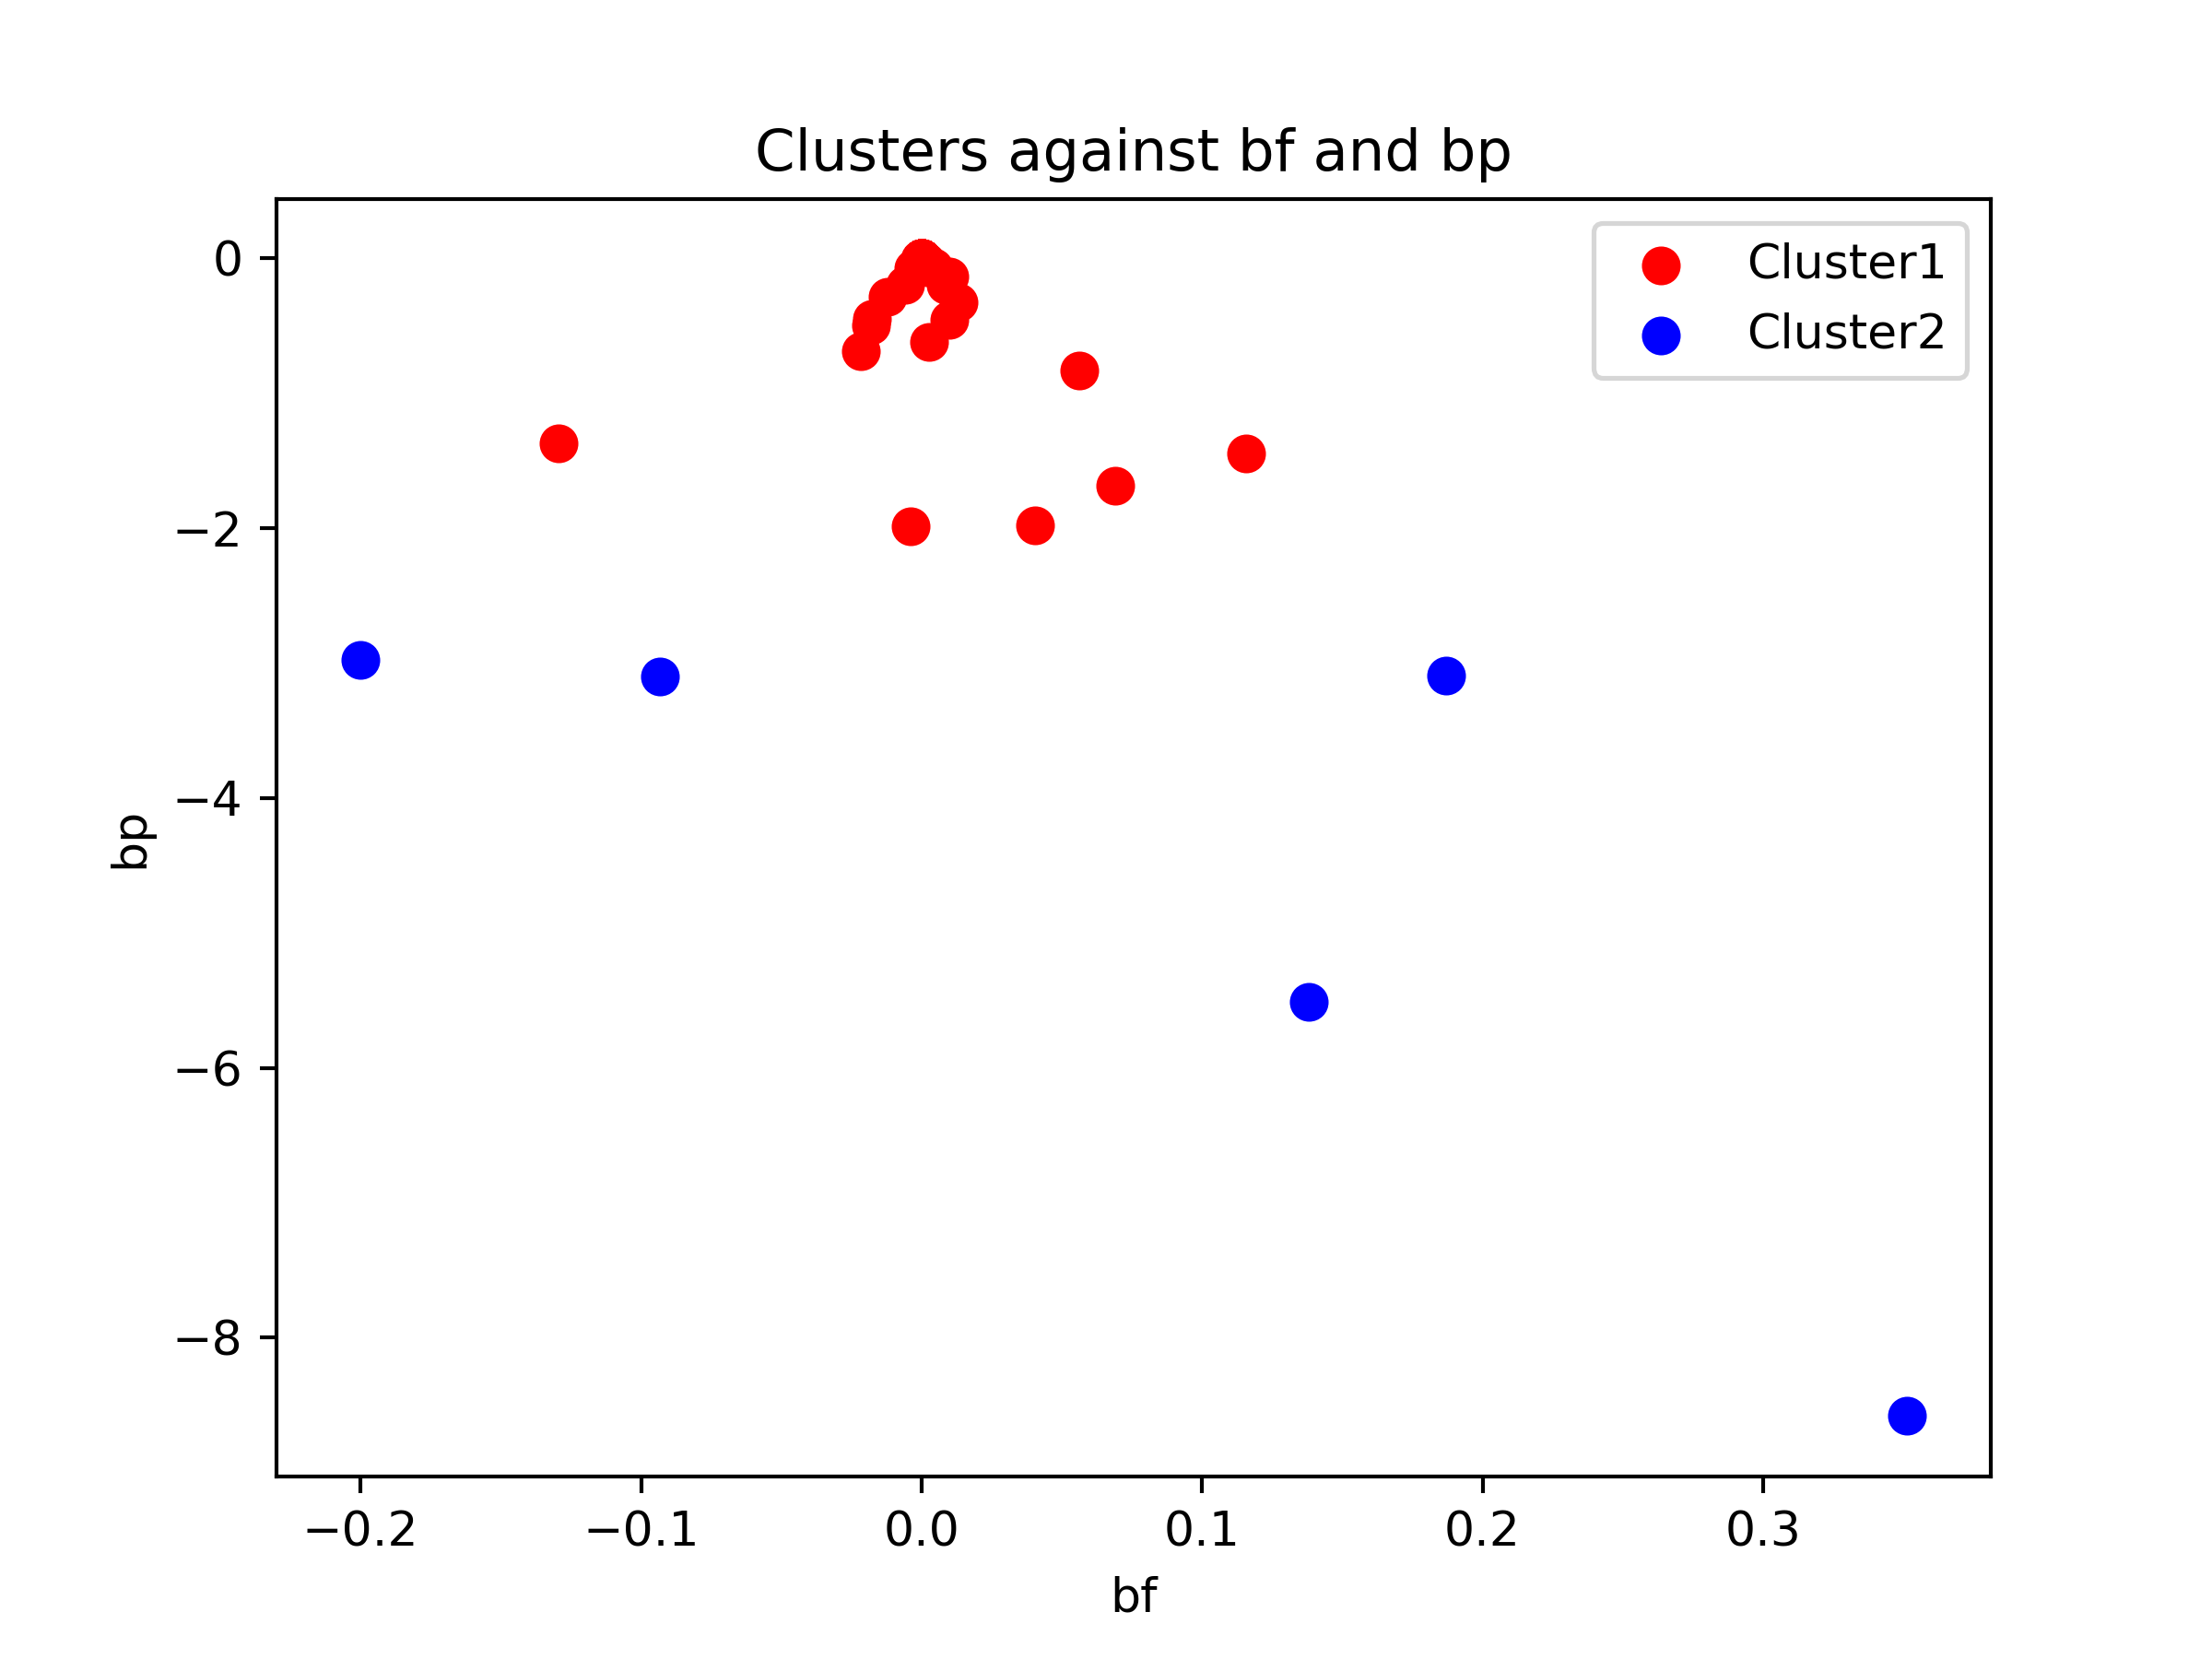

In [215]:
#Visualizing the clusters for k=2
C1=para[para["Cluster"] == 0]
C2=para[para["Cluster"] == 1]

plt.scatter(C1["bf"],C1["bp"],s=50, c='red',label='Cluster1')
plt.scatter(C2["bf"],C2["bp"],s=50, c='blue',label='Cluster2')

plt.title('Clusters against bf and bp')
plt.xlabel('bf')
plt.ylabel('bp')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


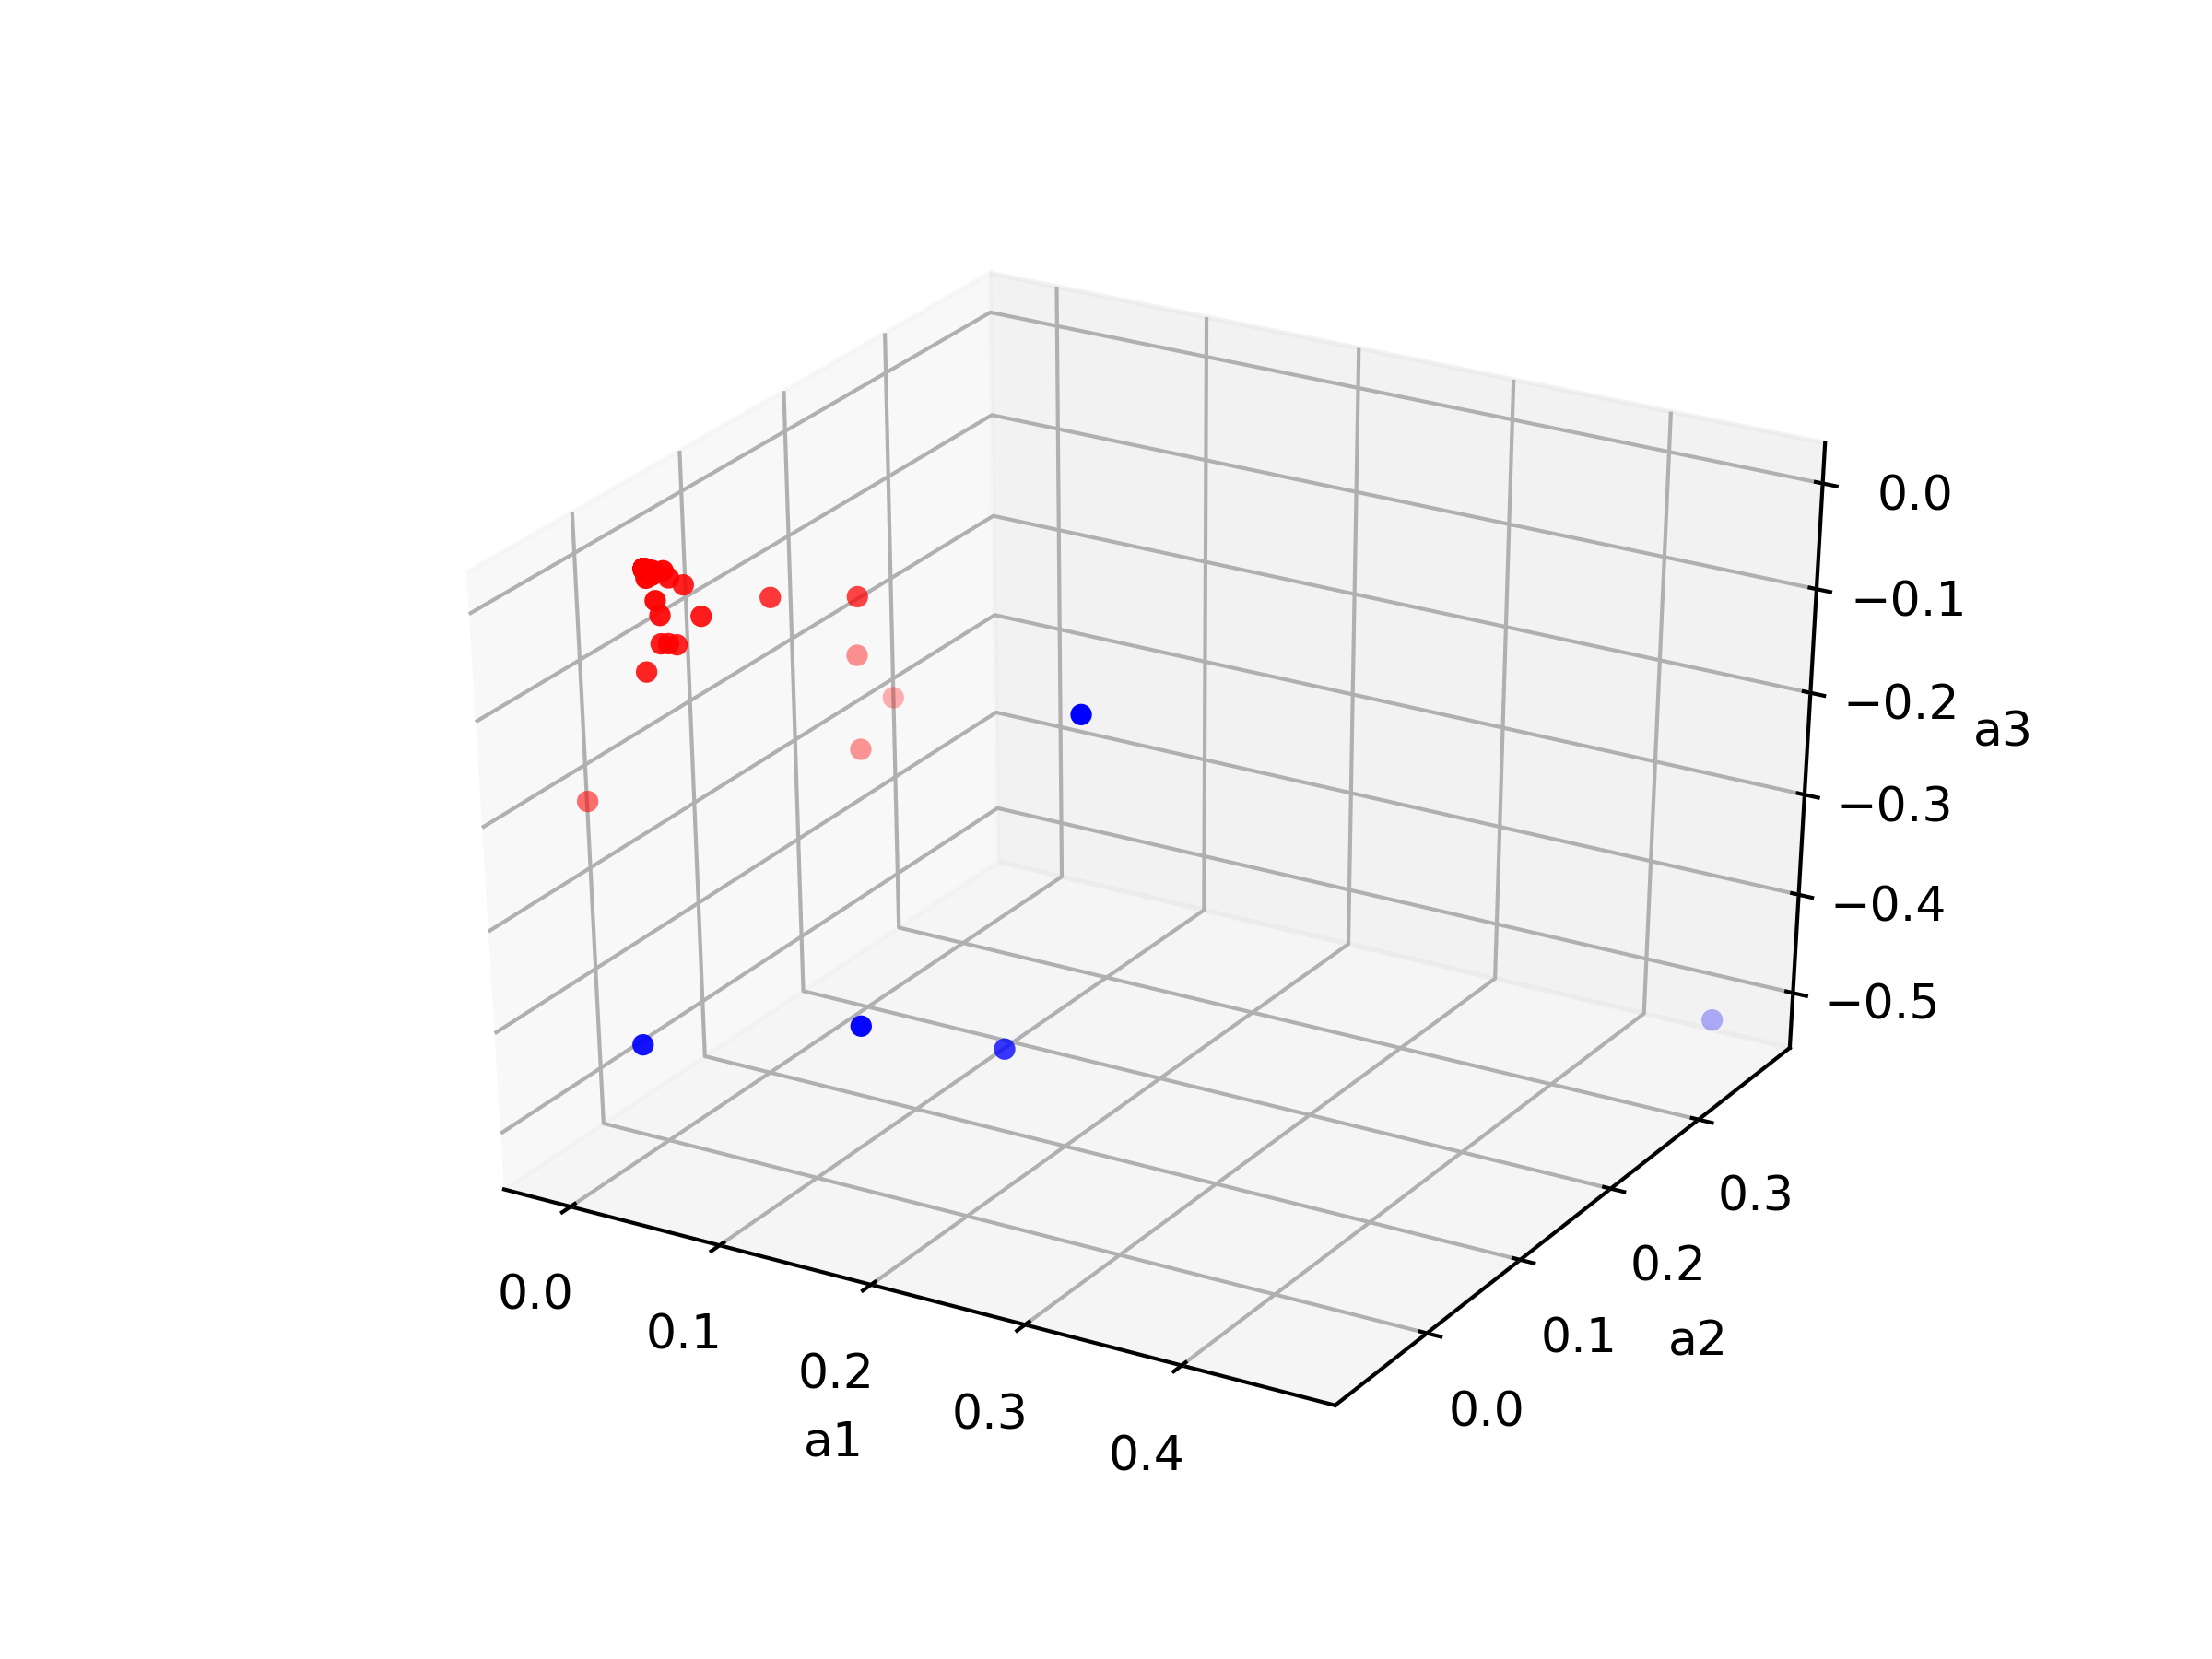

In [214]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(C1["a1"], C1["a2"], C1["a3"],c='red',label='Cluster1',cmap='viridis',linewidth=0)
ax.scatter(C2["a1"], C2["a2"], C2["a3"],c='blue',label='Cluster1',cmap='viridis',linewidth=0)

ax.set_xlabel('a1')
ax.set_ylabel('a2')
ax.set_zlabel('a3')
plt.show()

In [209]:
#Import posterior assignment results of iscrete heterogeneity model from PS4
disc=[0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1]
para['disc']=disc

In [207]:
sum(para['disc']==para['Cluster'])

49

49% of the households are assigned with the same clusters in discrete heterogeneity model and random coefficients model.